In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample

C:\Users\syj47\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
uploaded_file_name = 'test.wav'
EXPECTED_SAMPLE_RATE = 44100

def convert_audio_for_model(user_file, output_file = 'test2.wav'):
    audio = AudioSegment.from_file(user_file, format = "wav")
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

converted_audio_file = convert_audio_for_model(uploaded_file_name)

# Loading audio samples from the wav file : 
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

In [3]:
# 오디오 정보 출력
duration = len(audio_samples)/sample_rate
print("data :", audio_samples)
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

data : [ 1025  3071  5121 ... -5628 -3588 -1534]
Sample rate: 44100 Hz
Total duration: 5.75s
Size of the input: 253440


[ 1.025  3.071  5.121 ... -5.628 -3.588 -1.534]


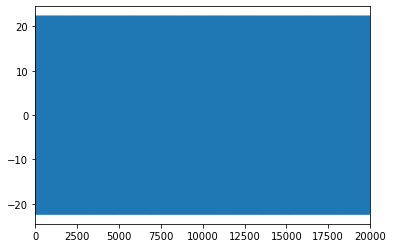

In [4]:
pd.DataFrame(audio_samples).to_csv("test.csv")
data = pd.read_csv('test.csv')
train_data = data['0'].values/1000
print(train_data)

# 파형 그래프 출력
plt.plot(train_data)
plt.xlim(0,20000)
plt.show()

In [5]:
pd.DataFrame(audio_samples).to_csv("original.csv")
data = pd.read_csv('original.csv')
print(data['0'].describe())
train_data = data['0'].values
print(train_data)

count    253440.000000
mean          0.022727
std       13317.174470
min      -22273.000000
25%      -11454.500000
50%         127.000000
75%       11585.000000
max       22271.000000
Name: 0, dtype: float64
[ 1025  3071  5121 ... -5628 -3588 -1534]


In [6]:
# 5초 간의 데이터를 보고 다음을 예측
seq_len = 50  #예측을 위한 데이터 수
prediction = 1  # 다음을 예측할 데이터 수 
print("seq_len : ", seq_len)
sequence_length = seq_len + prediction

seq_len :  50


In [7]:
# 정확한 예측을 위해 값들을 정규화 
result = []
for index in range(len(train_data) - sequence_length):
    result.append(train_data[index: index + sequence_length])
result = np.array(result)

# result_df = pd.DataFrame(result)
# result_df.dropna(axis=0, inplace=True)
# result = result_df.values

# 트레이닝할 값과 테스트 값을 나눠줌
row = int(round(result.shape[0] * 0.8))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-prediction]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -prediction]

x_val = result[row:, :-prediction]
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
y_val = result[row:, -prediction]
y_val = y_val.astype(np.float32)
wavfile.write("y_val.wav", EXPECTED_SAMPLE_RATE, y_val.reshape(-1, 1))

print("y_val dtype", y_val.dtype)
print("y_val shape", y_val.shape)
print("y_val shape : ", y_val.reshape(-1, 1).shape)

y_val dtype float32
y_val shape (50678,)
y_val shape :  (50678, 1)


In [8]:
# 모델 생성
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop', metrics=["acc"])
model.summary()

# 트레이닝 값으로 학습
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=100)

# 모델 저장
model.save('weight.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20272/20272 [==============================] - 516s 25ms/step - loss: 170077944.3792 - acc: 0.0000e+00 - val_loss: 149464080.0000 - val_acc: 0.0000e+00
Epoch 2/100
20272/20272 [==============================] - 488s 24ms/step - loss: 143877533.0329 - acc: 0.0000e+00 - val_loss: 125115616.0000 - val_acc: 0.0000e+00
Epoch 3/100
20272/20272 [=============================

20272/20272 [==============================] - 457s 23ms/step - loss: 44188575.5949 - acc: 0.0000e+00 - val_loss: 44227868.0000 - val_acc: 0.0000e+00
Epoch 47/100
20272/20272 [==============================] - 445s 22ms/step - loss: 44270634.4991 - acc: 0.0000e+00 - val_loss: 44226312.0000 - val_acc: 0.0000e+00
Epoch 48/100
20272/20272 [==============================] - 446s 22ms/step - loss: 44169776.2443 - acc: 0.0000e+00 - val_loss: 44222856.0000 - val_acc: 0.0000e+00
Epoch 49/100
20272/20272 [==============================] - 446s 22ms/step - loss: 44112162.4330 - acc: 0.0000e+00 - val_loss: 44221576.0000 - val_acc: 0.0000e+00
Epoch 50/100
20272/20272 [==============================] - 445s 22ms/step - loss: 44334142.3874 - acc: 0.0000e+00 - val_loss: 44219540.0000 - val_acc: 0.0000e+00
Epoch 51/100
20272/20272 [==============================] - 445s 22ms/step - loss: 44151879.0642 - acc: 0.0000e+00 - val_loss: 44216868.0000 - val_acc: 0.0000e+00
Epoch 52/100
20272/20272 [=========

20272/20272 [==============================] - 1151s 57ms/step - loss: 44028022.7613 - acc: 0.0000e+00 - val_loss: 44150336.0000 - val_acc: 0.0000e+00
Epoch 96/100
20272/20272 [==============================] - 1636s 81ms/step - loss: 44172375.1646 - acc: 0.0000e+00 - val_loss: 44149508.0000 - val_acc: 0.0000e+00
Epoch 97/100
20272/20272 [==============================] - 1158s 57ms/step - loss: 44122326.6630 - acc: 0.0000e+00 - val_loss: 44148344.0000 - val_acc: 0.0000e+00
Epoch 98/100
20272/20272 [==============================] - 1884s 93ms/step - loss: 43974598.8609 - acc: 0.0000e+00 - val_loss: 44147040.0000 - val_acc: 0.0000e+00
Epoch 99/100
20272/20272 [==============================] - 1660s 82ms/step - loss: 44059294.1731 - acc: 0.0000e+00 - val_loss: 44146968.0000 - val_acc: 0.0000e+00
Epoch 100/100
20272/20272 [==============================] - 1267s 63ms/step - loss: 44117388.1591 - acc: 0.0000e+00 - val_loss: 44145272.0000 - val_acc: 0.0000e+00


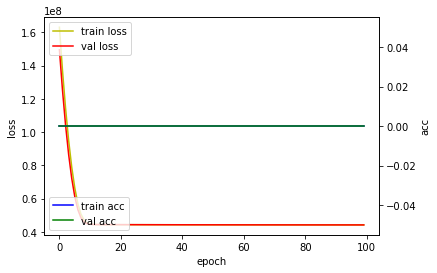

In [9]:
# 모델 학습 과정 표시
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [10]:
# 모델 로드
model = Sequential()
model = load_model('weight.h5')

In [11]:
pred = model.predict(x_val)
print(pred)

[[ 11245.994]
 [ 11245.994]
 [ 11245.994]
 ...
 [-11846.486]
 [-11846.486]
 [-11846.486]]


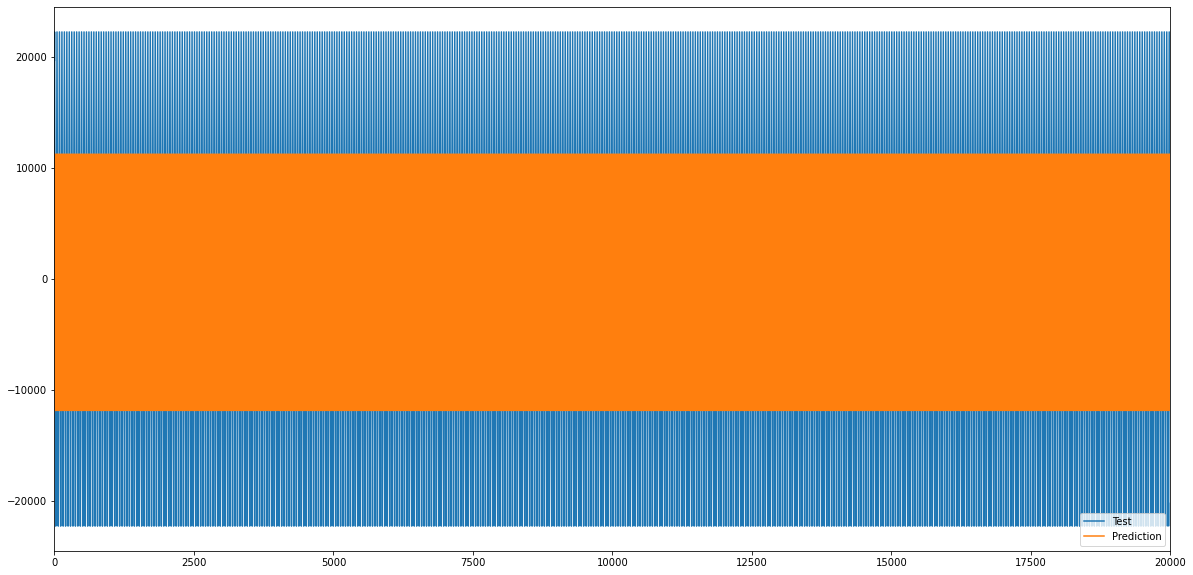

In [12]:
# 그래프 
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_val, label='Test')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlim(0,20000)
plt.show()

In [13]:
# 예측값을 wav로 출력
wavfile.write("pred.wav", EXPECTED_SAMPLE_RATE, pred)
print("pred dtype", pred.dtype)
print("pred shape : ", pred.shape)

print("end")

pred dtype float32
pred shape :  (50678, 1)
end
